In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()



In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
from tensorflow.keras import utils

data_url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Toys_v1_00.tsv.gz'

dataset_dir = tf.keras.utils.get_file('amazon_reviews_us_Toys_v1_00.tsv.gz',
    origin=data_url,
    untar=False,
    cache_dir='.',
    cache_subdir='',
    extract=True
    )

838467584/838451398 [==============================] - 15s 0us/step


In [5]:
import gzip
import shutil
with gzip.open('amazon_reviews_us_Toys_v1_00.tsv.gz') as f_in:
    with open('amazon_reviews_us_Toys_v1_00.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
import pandas as pd
raw_data = pd.read_csv('/content/amazon_reviews_us_Toys_v1_00.tsv', sep='\t',error_bad_lines=False)

b'Skipping line 7003: expected 15 fields, saw 22\nSkipping line 22430: expected 15 fields, saw 22\nSkipping line 25418: expected 15 fields, saw 22\nSkipping line 43786: expected 15 fields, saw 22\nSkipping line 46566: expected 15 fields, saw 22\nSkipping line 63511: expected 15 fields, saw 22\n'
b'Skipping line 69097: expected 15 fields, saw 22\nSkipping line 74615: expected 15 fields, saw 22\nSkipping line 79354: expected 15 fields, saw 22\nSkipping line 81566: expected 15 fields, saw 22\nSkipping line 89464: expected 15 fields, saw 22\nSkipping line 93104: expected 15 fields, saw 22\nSkipping line 95570: expected 15 fields, saw 22\nSkipping line 96587: expected 15 fields, saw 22\nSkipping line 102117: expected 15 fields, saw 22\nSkipping line 121288: expected 15 fields, saw 22\n'
b'Skipping line 144424: expected 15 fields, saw 22\nSkipping line 168191: expected 15 fields, saw 22\nSkipping line 173291: expected 15 fields, saw 22\n'
b'Skipping line 199932: expected 15 fields, saw 22\nS

In [7]:
raw_data.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18778586,RDIJS7QYB6XNR,B00EDBY7X8,122952789,Monopoly Junior Board Game,Toys,5.0,0.0,0.0,N,Y,Five Stars,Excellent!!!,2015-08-31
1,US,24769659,R36ED1U38IELG8,B00D7JFOPC,952062646,56 Pieces of Wooden Train Track Compatible wit...,Toys,5.0,0.0,0.0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31
2,US,44331596,R1UE3RPRGCOLD,B002LHA74O,818126353,Super Jumbo Playing Cards by S&S Worldwide,Toys,2.0,1.0,1.0,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31
3,US,23310293,R298788GS6I901,B00ARPLCGY,261944918,Barbie Doll and Fashions Barbie Gift Set,Toys,5.0,0.0,0.0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31
4,US,38745832,RNX4EXOBBPN5,B00UZOPOFW,717410439,Emazing Lights eLite Flow Glow Sticks - Spinni...,Toys,1.0,1.0,1.0,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859607 entries, 0 to 4859606
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 556.1+ MB


In [9]:
data = raw_data.copy()
data = data[:10000]

In [10]:
data.dropna(inplace=True)

In [11]:
import numpy as np
data['star_rating'] = data['star_rating'].astype(int)
data_dataset = data[['review_body','star_rating']]
train, val, test = np.split(data_dataset.sample(frac=1), [int(0.8*len(data_dataset)), int(0.9*len(data_dataset))])

In [12]:
def change_to_ds(df):
  labels = df.pop('star_rating')
  dataset = tf.data.Dataset.from_tensor_slices((df,labels))
  return dataset


train_dataset = change_to_ds(train)
val_dataset = change_to_ds(val)
test_dataset = change_to_ds(test)

In [13]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [14]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'it has a great likeness of Dr. Strange and the Silver surfer']
label:  5


In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 4, 64,  5, 18,  1, 11,  1,  1,  3,  2,  1,  1]])

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=30,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/30
125/125 [==============================] - 19s 156ms/step - loss: -2483.7341 - accuracy: 0.0707 - val_loss: -2560.8638 - val_accuracy: 0.0790
Epoch 2/30
125/125 [==============================] - 18s 141ms/step - loss: -2669.1101 - accuracy: 0.0707
Epoch 3/30
125/125 [==============================] - 18s 148ms/step - loss: -2859.6245 - accuracy: 0.0707
Epoch 4/30
125/125 [==============================] - 17s 140ms/step - loss: -3055.2195 - accuracy: 0.0707
Epoch 5/30
125/125 [==============================] - 21s 168ms/step - loss: -3255.8298 - accuracy: 0.0707
Epoch 6/30
125/125 [==============================] - 21s 167ms/step - loss: -3461.3979 - accuracy: 0.0707
Epoch 7/30
125/125 [==============================] - 17s 136ms/step - loss: -3671.8362 - accuracy: 0.0707
Epoch 8/30
125/125 [==============================] - 18s 143ms/step - loss: -3887.0874 - accuracy: 0.0707
Epoch 9/30
125/125 [==============================] - 18s 145ms/step - loss: -4107.2227 - accuracy

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 [==============================] - 1s 50ms/step - loss: -2379.1260 - accuracy: 0.0790
Test Loss: -2379.1259765625
Test Accuracy: 0.07900000363588333


(0.0, 110.73145945072174)

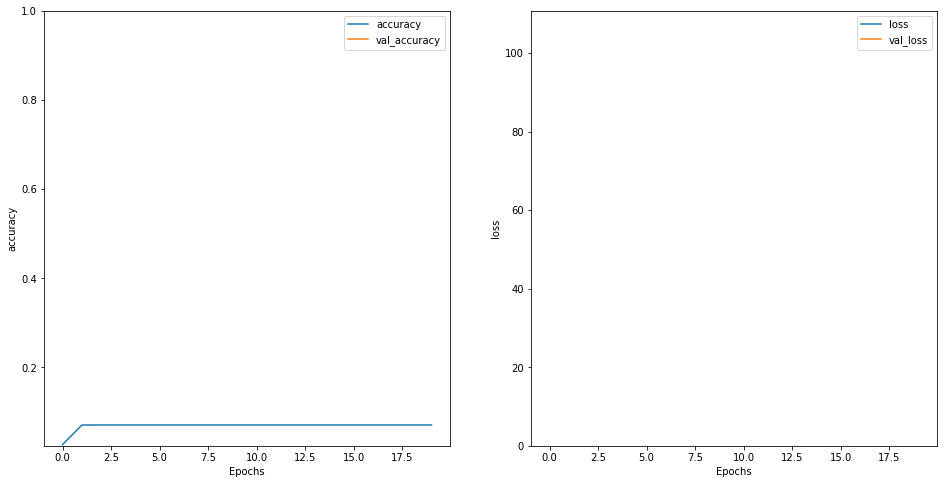

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)